# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import pandas as pd


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

<font color='blue'>* The head and tail of the dataset
</font>

In [3]:
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
websites.tail()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
1776,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0,1
1777,M4_41,198,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,2,124,0,0,0.0,1
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,15/02/1999 0:00,15/07/2015 0:00,83,2,6,6631,87,89,132181,6945,87,4.0,0
1779,B0_1152,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,1/04/1998 0:00,9/12/2016 0:00,0,0,0,0,0,0,0,0,0,0.0,0
1780,B0_676,249,40,utf-8,Microsoft-IIS/8.5,24435.0,US,Wisconsin,14/11/2008 0:00,20/11/2013 0:00,19,6,11,2314,25,28,3039,2776,25,6.0,0


<font color='blue'>* The shape of the dataset:
</font>

In [5]:
websites.shape

(1781, 21)

<font color='blue'> We have 1781 rows and 21 columns</font>

<font color='blue'>* The types of each column:
</font>

In [6]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

<font color='blue'>There are 14 numerical vars and 3 categorical vars.
</font> 

<font color='blue'>* Check the nulls per column:
</font>

In [7]:
websites.isnull().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

<font color='blue'>Content Leght has almost 50% of the rows without a value.
</font>

<font color='blue'>* Check the numerical vars details:
</font>

In [8]:
websites.describe().T

,count,mean,std,min,25%,50%,75%,max
URL_LENGTH,1781.0,56.961258,27.555586,16.0,39.0,49.0,68.0,249.0
NUMBER_SPECIAL_CHARACTERS,1781.0,11.111735,4.549896,5.0,8.0,10.0,13.0,43.0
CONTENT_LENGTH,969.0,11726.927761,36391.809051,0.0,324.0,1853.0,11323.0,649263.0
TCP_CONVERSATION_EXCHANGE,1781.0,16.261089,40.500975,0.0,0.0,7.0,22.0,1194.0
DIST_REMOTE_TCP_PORT,1781.0,5.472768,21.807327,0.0,0.0,0.0,5.0,708.0
REMOTE_IPS,1781.0,3.060640,3.386975,0.0,0.0,2.0,5.0,17.0
APP_BYTES,1781.0,2982.339135,56050.574748,0.0,0.0,672.0,2328.0,2362906.0
SOURCE_APP_PACKETS,1781.0,18.540146,41.627173,0.0,0.0,8.0,26.0,1198.0
REMOTE_APP_PACKETS,1781.0,18.746210,46.397969,0.0,0.0,9.0,25.0,1284.0
SOURCE_APP_BYTES,1781.0,15892.545761,69861.929888,0.0,0.0,579.0,9806.0,2060012.0


<font color='blue'>**Type** seems to be boolean as it only has values 0 an 1. Let's check it
</font>

In [9]:
websites.Type.unique()

array([1, 0])

<font color='blue'>Let's check the categorical vars:
</font>

In [10]:
websites.describe(include='O').T

,count,unique,top,freq
URL,1781,1781,B0_435,1
CHARSET,1781,9,UTF-8,676
SERVER,1780,239,Apache,386
WHOIS_COUNTRY,1781,49,US,1103
WHOIS_STATEPRO,1781,182,CA,372
WHOIS_REGDATE,1781,891,None,127
WHOIS_UPDATED_DATE,1781,594,None,139


<font color='blue'>
- The URL var seems to be a unique value for each row. <br>
- The WHOIS_REGDATE and WHOIS_UPDATED_DATE seems to have a very common value None, than has to be treated as a NaN, that is arround the 7-8% of the values.
</font>

<font color='blue'>* Let's check the unique values for each column:
</font>

In [11]:
for x in websites.columns:
    print(x)
    print(websites[x].unique())
    print('----------------------------------------')

URL
['M0_109' 'B0_2314' 'B0_911' ... 'B0_162' 'B0_1152' 'B0_676']
----------------------------------------
URL_LENGTH
[ 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 120 122 123 124 125
 126 128 129 131 132 134 135 136 137 139 140 141 142 143 144 145 146 149
 150 151 154 156 160 161 169 170 173 178 183 194 198 201 234 249]
----------------------------------------
NUMBER_SPECIAL_CHARACTERS
[ 7  6  5  8  9 11 10 13 12 14 15 16 17 18 21 19 20 22 23 28 24 25 36 26
 27 43 30 29 31 34 40]
----------------------------------------
CHARSET
['iso-8859-1' 'UTF-8' 'us-ascii' 'ISO-8859-1' 'utf-8' 'None'
 'windows-1251' 'ISO-8859' 'wind

<font color='blue'>* Which columns contain the features of the websites?
</font>

URL<br>
URL_LENGTH<br>
NUMBER_SPECIAL_CHARACTERS<br>
CHARSET<br>
SERVER<br>
CONTENT_LENGTH<br>
WHOIS_COUNTRY<br>
WHOIS_STATEPRO<br>
WHOIS_REGDATE<br>
WHOIS_UPDATED_DATE<br>
TCP_CONVERSATION_EXCHANGE<br>
DIST_REMOTE_TCP_PORT           <br> 
REMOTE_IPS                     <br> 
APP_BYTES                      <br> 
SOURCE_APP_PACKETS             <br> 
REMOTE_APP_PACKETS             <br> 
SOURCE_APP_BYTES               <br> 
REMOTE_APP_BYTES               <br> 
APP_PACKETS                    <br> 
DNS_QUERY_TIMES                <br> 

<font color='blue'>* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
</font>

Type<br>
1 --> Malicious<br>
0 --> Benign<br>

<font color='blue'>* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?
</font>

The categorical columns:<br>
URL --> no repeated values --> not usefulll <br>
CHARSET --> 8 categories + none --> should be transformed <br>
SERVER --> To many types, maybe we can extract only the main names "Apache", "microsoft", "ngix", and then transform it to categorical<br>
WHOIS_COUNTRY --> Need to be fixed and then can be convert into ordinal<br>
WHOIS_STATEPRO --> To many values<br>
WHOIS_REGDATE --> Should be date<br>
WHOIS_UPDATED_DATE --> Should be date<br>


#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [12]:
# Your code here
correlation = websites.corr()

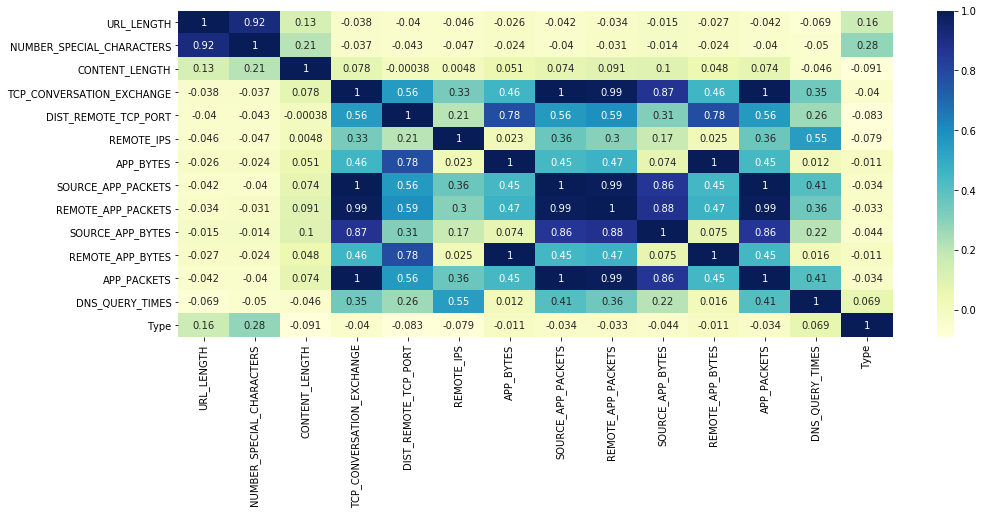

In [13]:
# Your comment here
plt.figure(figsize=(16, 6))
sns.heatmap(correlation, cmap="YlGnBu", annot=True)
plt.show()

<font color='blue'>Las variables altamente correlacionadas son:
</font>

In [14]:
correlation.loc['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS']

0.9179859625469562

In [15]:
correlation

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


In [16]:
for y in correlation.columns:
    for z in correlation.columns:
        if y != z and (correlation.loc[y,z]>0.90 or correlation.loc[y,z]<-0.90):
            print(f'{y},{z},{correlation.loc[y,z]}')
            

URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,0.9179859625469562
NUMBER_SPECIAL_CHARACTERS,URL_LENGTH,0.9179859625469562
TCP_CONVERSATION_EXCHANGE,SOURCE_APP_PACKETS,0.997796267211846
TCP_CONVERSATION_EXCHANGE,REMOTE_APP_PACKETS,0.99084845599245
TCP_CONVERSATION_EXCHANGE,APP_PACKETS,0.997796267211846
APP_BYTES,REMOTE_APP_BYTES,0.9999919769069622
SOURCE_APP_PACKETS,TCP_CONVERSATION_EXCHANGE,0.997796267211846
SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,0.9892845554495483
SOURCE_APP_PACKETS,APP_PACKETS,1.0
REMOTE_APP_PACKETS,TCP_CONVERSATION_EXCHANGE,0.99084845599245
REMOTE_APP_PACKETS,SOURCE_APP_PACKETS,0.9892845554495483
REMOTE_APP_PACKETS,APP_PACKETS,0.9892845554495483
REMOTE_APP_BYTES,APP_BYTES,0.9999919769069622
APP_PACKETS,TCP_CONVERSATION_EXCHANGE,0.997796267211846
APP_PACKETS,SOURCE_APP_PACKETS,1.0
APP_PACKETS,REMOTE_APP_PACKETS,0.9892845554495483


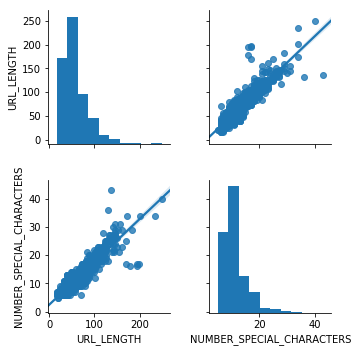

In [17]:
sns.pairplot(data=websites[['URL_LENGTH','NUMBER_SPECIAL_CHARACTERS']],kind="reg")
plt.show()

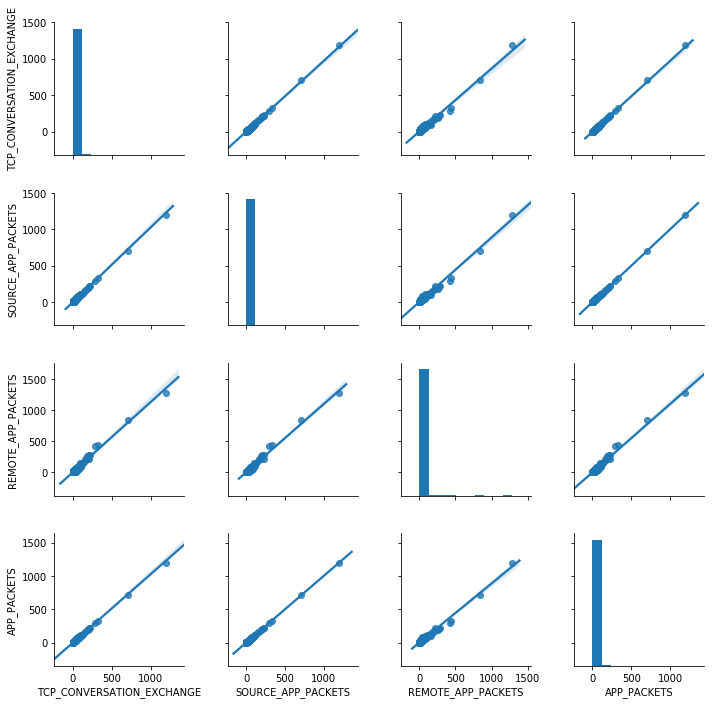

In [18]:
sns.pairplot(data=websites[['TCP_CONVERSATION_EXCHANGE','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','APP_PACKETS']],kind="reg")
plt.show()

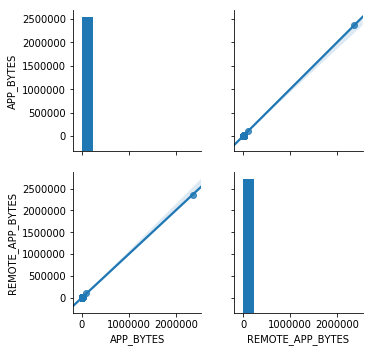

In [19]:
sns.pairplot(data=websites[['APP_BYTES','REMOTE_APP_BYTES']],kind="reg")
plt.show()

<font color='blue'>We have three groups of very linear correlated, we will only leave one of the vars per group.</font>

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [20]:
# Your code here
columns_to_drop = ['NUMBER_SPECIAL_CHARACTERS','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','APP_PACKETS','REMOTE_APP_BYTES']

In [21]:
# Your comment here
websites_clean = websites.drop(columns=columns_to_drop)

In [22]:
# Print heatmap again
correlation_clean = websites_clean.corr()

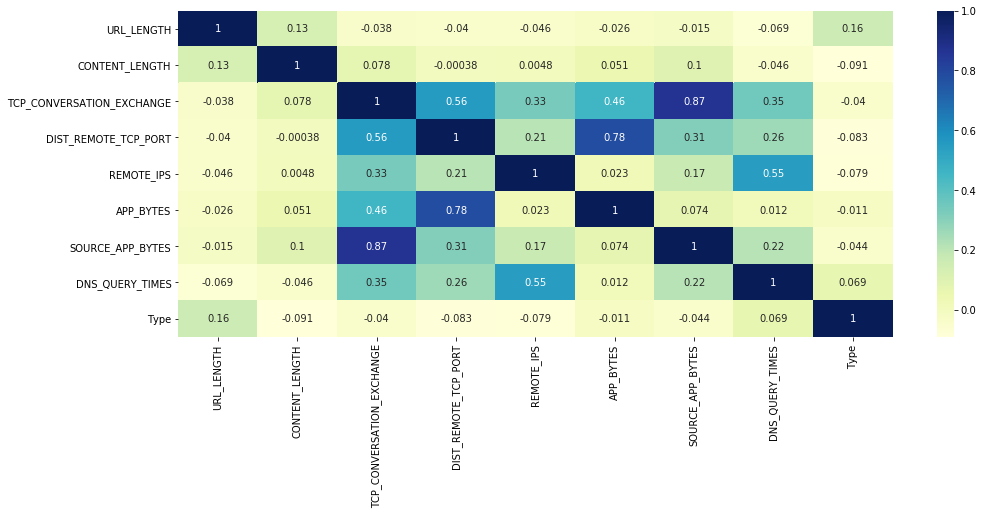

In [23]:
# Your comment here
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_clean, cmap="YlGnBu", annot=True)
plt.show()

<font color='blue'>There is a column,SOURCE APP BYTES, that may be droped but for the moment I keep it 
</font>

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [24]:
# Your code here
websites_clean.isnull().sum()

URL                            0
URL_LENGTH                     0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [25]:
# Your code here
websites_clean.CONTENT_LENGTH.isnull().sum()/websites_clean.shape[0]

0.45592363840539024

In [26]:
websites_clean[['CONTENT_LENGTH','Type']].corr()

,CONTENT_LENGTH,Type
CONTENT_LENGTH,1.000000,-0.090852
Type,-0.090852,1.000000


<font color='blue'>45% of the column CONTENT_LENGTH is empty. <br>
Also, the column is not very correlated with the target var. <br>
So we will delete the column.
</font>

In [27]:
# Your comment here
websites_clean.drop(columns='CONTENT_LENGTH', inplace=True)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [28]:
# Examine missing values in each column
websites_clean.isnull().sum()

URL                          0
URL_LENGTH                   0
CHARSET                      0
SERVER                       1
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              1
Type                         0
dtype: int64

In [29]:
websites_clean.loc[(websites_clean.DNS_QUERY_TIMES.isnull()) | (websites_clean.SERVER.isnull())]

,URL,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
1306,B0_2134,66,UTF-8,NaN,US,District of Columbia,1/02/2003 16:44,2/02/2017 17:11,15,2,4,1026,246,0.0,0
1659,B0_772,101,UTF-8,Apache,CA,ON,14/12/2009 0:00,13/12/2016 0:00,4,2,2,276,416,NaN,0


<font color='blue'>The two rows can be deleted, to clear all the NaN
</font>

In [30]:
websites_clean.dropna('index', inplace=True)

In [31]:
websites_clean.isnull().sum()

URL                          0
URL_LENGTH                   0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

<font color='blue'>We do not have any more null values
</font>

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [32]:
# Your code here
websites_clean.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [33]:
def replace_country(x):
    if x == 'Cyprus':
        x = 'CY'
    elif x == 'us':
        x = 'US'
    elif x == 'United Kingdom' or x == "[u'GB'; u'UK']":
        x = 'UK'        
    elif x == 'se':
        x = 'SE'        
    else:
        x = x
    return x

In [34]:
websites_clean.WHOIS_COUNTRY = websites_clean.WHOIS_COUNTRY.apply(lambda x: replace_country(x))

In [35]:
websites_clean.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN',
       'LU', 'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'ru', 'KY',
       'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR',
       'HK', 'UA', 'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY',
       'KG'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [36]:
# Your code here
websites_clean.WHOIS_COUNTRY.value_counts().head(11)

US      1105
None     306
CA        83
ES        63
AU        35
PA        21
GB        19
UK        16
JP        11
IN        10
CN        10
Name: WHOIS_COUNTRY, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [37]:
# Your code here
list_keep = ['US','CA', 'ES', 'AU', 'PA', 'GB', 'UK', 'JP', 'IN', 'CN']
websites_clean.WHOIS_COUNTRY = websites_clean.WHOIS_COUNTRY.apply(lambda x: x if x in list_keep else 'OTHER')

In [38]:
websites_clean.WHOIS_COUNTRY.value_counts()

US       1105
OTHER     406
CA         83
ES         63
AU         35
PA         21
GB         19
UK         16
JP         11
IN         10
CN         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [39]:
# Your code here
websites_clean.drop(columns=['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], inplace=True)

In [40]:
websites_clean.head()

,URL,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,16,iso-8859-1,nginx,OTHER,7,0,2,700,1153,2.0,1
1,B0_2314,16,UTF-8,Apache/2.4.10,OTHER,17,7,4,1230,1265,0.0,0
2,B0_911,16,us-ascii,Microsoft-HTTPAPI/2.0,OTHER,0,0,0,0,0,0.0,0
3,B0_113,17,ISO-8859-1,nginx,US,31,22,3,3812,18784,8.0,0
4,B0_403,17,UTF-8,None,US,57,2,5,4278,129889,4.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [41]:
# Your code here
websites_clean.dtypes

URL                           object
URL_LENGTH                     int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [42]:
# Your code here
websites_clean.drop(columns=['URL'], inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [43]:
# Your code here
websites_clean.CHARSET.value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1251      1
windows-1252      1
ISO-8859          1
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [44]:
# Your code here
websites_clean.SERVER.value_counts()

Apache                                                                                                                                                                         385
nginx                                                                                                                                                                          211
None                                                                                                                                                                           175
Microsoft-HTTPAPI/2.0                                                                                                                                                          113
cloudflare-nginx                                                                                                                                                                94
Microsoft-IIS/7.5                                                                                        

![Think Hard](../images/think-hard.jpg)

<font color='blue'>I think we can extract the main name of the server and do not take into account the detailed info. <br>
For instance in 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips ' just keep the 'Apache'.
</font>

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [45]:
def replace_server(x):
    if 'Microsoft' in x:
        x = 'Microsoft'
    elif 'Apache' in x:
        x = 'Apache'           
    elif 'nginx' in x:
        x = 'nginx'      
    else:
        x = 'Other'
    return x

In [46]:
# Your code here
websites_clean.SERVER = websites_clean.SERVER.apply(lambda x: replace_server(x))

In [47]:
# Count `SERVER` value counts here
websites_clean.SERVER.value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [48]:
# Your code here
website_dummy = pd.get_dummies(websites_clean, drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [49]:
# Your code here
website_dummy.dtypes

URL_LENGTH                     int64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
CHARSET_ISO-8859-1             uint8
CHARSET_None                   uint8
CHARSET_UTF-8                  uint8
CHARSET_iso-8859-1             uint8
CHARSET_us-ascii               uint8
CHARSET_utf-8                  uint8
CHARSET_windows-1251           uint8
CHARSET_windows-1252           uint8
SERVER_Microsoft               uint8
SERVER_Other                   uint8
SERVER_nginx                   uint8
WHOIS_COUNTRY_CA               uint8
WHOIS_COUNTRY_CN               uint8
WHOIS_COUNTRY_ES               uint8
WHOIS_COUNTRY_GB               uint8
WHOIS_COUNTRY_IN               uint8
WHOIS_COUNTRY_JP               uint8
WHOIS_COUNTRY_OTHER            uint8
WHOIS_COUNTRY_PA               uint8
W

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [50]:
website_dummy.columns

Index(['URL_LENGTH', 'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT',
       'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_BYTES', 'DNS_QUERY_TIMES',
       'Type', 'CHARSET_ISO-8859-1', 'CHARSET_None', 'CHARSET_UTF-8',
       'CHARSET_iso-8859-1', 'CHARSET_us-ascii', 'CHARSET_utf-8',
       'CHARSET_windows-1251', 'CHARSET_windows-1252', 'SERVER_Microsoft',
       'SERVER_Other', 'SERVER_nginx', 'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_ES', 'WHOIS_COUNTRY_GB', 'WHOIS_COUNTRY_IN',
       'WHOIS_COUNTRY_JP', 'WHOIS_COUNTRY_OTHER', 'WHOIS_COUNTRY_PA',
       'WHOIS_COUNTRY_UK', 'WHOIS_COUNTRY_US'],
      dtype='object')

In [51]:
website_dummy_x = website_dummy[['URL_LENGTH', 'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT',
       'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_BYTES', 'DNS_QUERY_TIMES',
       'CHARSET_ISO-8859-1', 'CHARSET_None', 'CHARSET_UTF-8',
       'CHARSET_iso-8859-1', 'CHARSET_us-ascii', 'CHARSET_utf-8',
       'CHARSET_windows-1251', 'CHARSET_windows-1252', 'SERVER_Microsoft',
       'SERVER_Other', 'SERVER_nginx', 'WHOIS_COUNTRY_CA', 'WHOIS_COUNTRY_CN',
       'WHOIS_COUNTRY_ES', 'WHOIS_COUNTRY_GB', 'WHOIS_COUNTRY_IN',
       'WHOIS_COUNTRY_JP', 'WHOIS_COUNTRY_OTHER', 'WHOIS_COUNTRY_PA',
       'WHOIS_COUNTRY_UK', 'WHOIS_COUNTRY_US']]
website_dummy_y = website_dummy['Type']

In [52]:
from sklearn.model_selection import train_test_split
# Your code here:
X_train, X_test, y_train, y_test = train_test_split(website_dummy_x, website_dummy_y.values, test_size=0.2)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [53]:
# Your code here:
from sklearn.linear_model import LogisticRegression


Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [54]:
# Your code here:
y_train=y_train.reshape(len(y_train),)

ks_model = LogisticRegression(solver='lbfgs', max_iter=200).fit(X_train, y_train)


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [55]:
# Your code here:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

y_pred_test = ks_model.predict(X_test)
confusion_matrix(y_test, y_pred_test)

array([[300,   7],
       [ 24,  25]])

In [56]:
accuracy_score(y_test, y_pred_test)

0.9129213483146067

In [57]:
f1_score(y_test, y_pred_test)

0.617283950617284

In [58]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       307
           1       0.78      0.51      0.62        49

    accuracy                           0.91       356
   macro avg       0.85      0.74      0.78       356
weighted avg       0.91      0.91      0.90       356



What are your thoughts on the performance of the model? Write your conclusions below.

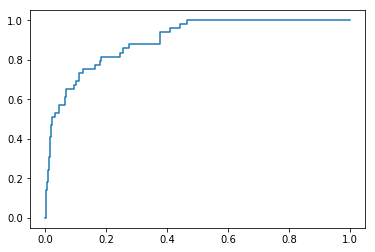

In [59]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from sklearn import metrics

#Consider a binary classification for labels 0 and 1.

#Predict will give either 0 or 1 as output
#Predict_proba will give the only probability of 1.

y_pred_proba = ks_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr)

In [60]:
auc

0.8985574685900418

<font color='blue'>**CONCLUSION:**<br></font>
<font color='blue'>
* The first impression with the accuracy test is that the model is quite good (0,918).<br>
* But lloking at the f1 score we see there is something that do sum up.<br>
* If we take a look at the classification repport, we can see that the model predicts quite well a 0, when the website is not malicious. But is not as good predicting if the web is malicious (0.58).<br>
* In conclusion, the model is not usefull as the inent of the prediction is to know wether or not a wesite is malicious.
</font>

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [61]:
# Your code here:
from sklearn.neighbors import KNeighborsClassifier
kn_3 = KNeighborsClassifier(n_neighbors=3)
kn_3.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [62]:
# Your code here:
y_pred_kn_3 = kn_3.predict(X_test)

In [63]:
accuracy_score(y_test, y_pred_kn_3)

0.9073033707865169

In [64]:
confusion_matrix(y_test, y_pred_kn_3)

array([[287,  20],
       [ 13,  36]])

In [65]:
f1_score(y_test, y_pred_kn_3)

0.6857142857142857

In [66]:
print(classification_report(y_test, y_pred_kn_3))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       307
           1       0.64      0.73      0.69        49

    accuracy                           0.91       356
   macro avg       0.80      0.83      0.82       356
weighted avg       0.91      0.91      0.91       356



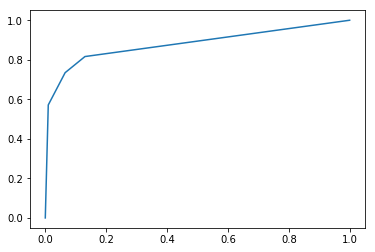

In [67]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from sklearn import metrics

#Consider a binary classification for labels 0 and 1.

#Predict will give either 0 or 1 as output
#Predict_proba will give the only probability of 1.

y_pred_proba = kn_3.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_kn_3 = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr)

In [68]:
auc_kn_3

0.8793126371069601

<font color='blue'>**CONCLUSION:**<br></font>
<font color='blue'>
* The first impression with the accuracy test is that in this the model is slighly better that the LinearRegression (0,927).<br>
* But looking at the f1 score we see is much better (0.7).<br>
* With the classification repport, we can see that the model predicts quite well a 0 (0.96) and more decently the malicious ones (0.7)
* The kneighbours is a better algorothm for this problem than the LinearRegression.
</font>

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [69]:
# Your code here:
kn_5 = KNeighborsClassifier(n_neighbors=5)
kn_5.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
y_pred_kn_5 = kn_5.predict(X_test)

In [71]:
accuracy_score(y_test, y_pred_kn_5)

0.9353932584269663

In [72]:
confusion_matrix(y_test, y_pred_kn_5)

array([[295,  12],
       [ 11,  38]])

In [73]:
f1_score(y_test, y_pred_kn_5)

0.7676767676767676

In [74]:
print(classification_report(y_test, y_pred_kn_5))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       307
           1       0.76      0.78      0.77        49

    accuracy                           0.94       356
   macro avg       0.86      0.87      0.87       356
weighted avg       0.94      0.94      0.94       356



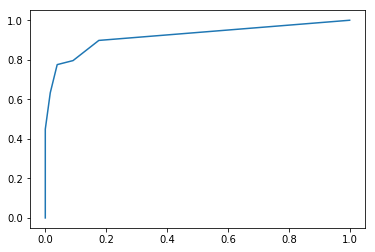

In [75]:
y_pred_proba = kn_5.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_kn5 = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr)

In [76]:
auc_kn5

0.9195971548228412

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

<font color='blue'>**CONCLUSION:**<br></font>
<font color='blue'>
* The acuracy improves slightly, but the f1 score, decreases. And the acuracy for the clasifiation of type 1 decreases too. So I do not think k=5 improves the model.
</font>

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [77]:
# Your code here
from sklearn.preprocessing import RobustScaler

In [78]:
transformer = RobustScaler().fit(X_train)

In [79]:
X_train_trans = transformer.transform(X_train)

In [80]:
X_test_trans = transformer.transform(X_test)

### Logistic Regresion with Feature Scalling

In [81]:
ks_model_sc = LogisticRegression(solver='lbfgs', max_iter=200).fit(X_train_trans, y_train)
y_pred_test_sc = ks_model_sc.predict(X_test_trans)
confusion_matrix(y_test, y_pred_test_sc)

array([[304,   3],
       [ 26,  23]])

In [82]:
accuracy_score(y_test, y_pred_test_sc)

0.9185393258426966

In [83]:
f1_score(y_test, y_pred_test_sc)

0.6133333333333333

In [84]:
print(classification_report(y_test, y_pred_test_sc))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       307
           1       0.88      0.47      0.61        49

    accuracy                           0.92       356
   macro avg       0.90      0.73      0.78       356
weighted avg       0.92      0.92      0.91       356



<font color='blue'>**CONCLUSION**:<br>
* The acuracy and f1 scores improve but very little
</font>

### K neighbours with Feature Scalling

In [85]:
kn_3_sc = KNeighborsClassifier(n_neighbors=3)
kn_3_sc.fit(X_train_trans, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [86]:
y_pred_kn_3_sc = kn_3_sc.predict(X_test_trans)

In [87]:
accuracy_score(y_test, y_pred_kn_3_sc)

0.9157303370786517

In [88]:
confusion_matrix(y_test, y_pred_kn_3_sc)

array([[292,  15],
       [ 15,  34]])

In [89]:
f1_score(y_test, y_pred_kn_3_sc)

0.6938775510204082

In [90]:
print(classification_report(y_test, y_pred_kn_3_sc))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       307
           1       0.69      0.69      0.69        49

    accuracy                           0.92       356
   macro avg       0.82      0.82      0.82       356
weighted avg       0.92      0.92      0.92       356



<font color='blue'>**CONCLUSION**:<br>
* In the K neighbours with k=3, the acuracy improves a bit.
* The f1 score improves from 0.67 to 0.69
* The most important for me is that th precision in recognising the malicious websites, has increased from 67% to 69%.
</font>